In [2]:
import pandas as pd
import glob
import json
from pprint import pprint 
import os
from tqdm.notebook import tqdm_notebook as tqdm
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords  # Import stopwords
import spacy 
import medspacy
from medspacy.custom_tokenizer import create_medspacy_tokenizer

# from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
# nltk.download('punkt')  # For word tokenization
# nltk.download('wordnet')  # For lemmatization




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

nlp = spacy.blank("en")
medspacy_tokenizer = create_medspacy_tokenizer(nlp)

# Data Formatting

####  Filter only seizure frequency and prescription associated tags

In [4]:
data_dir = "data/GoldStandardJSON/Json/"
file_list = glob.glob(data_dir + "*.json")
file_list[0], len(file_list)

('data/GoldStandardJSON/Json\\EA0001.json', 200)

In [5]:
def filter_data(file_list):
    new_file_list = []
    modified_path = "./data/modified_data"
    # create a folder path
    if not os.path.exists(modified_path):
        os.makedirs(modified_path, exist_ok=True)
    
    progress_bar = tqdm(total=len(file_list))
    # loop through the flle list
    for _file in file_list:
        _file_name = os.path.basename(_file)
        # load the data
        _json_data = json.load(open(_file, "r"))
        # filter the data
        _json_data = [i for i in _json_data if i["entity"] in ["SeizureFrequency", "Prescription"]]
        new_file_name = os.path.join(modified_path, _file_name)
        new_file_list.append(new_file_name)
        with open(new_file_name, "w") as fp:
            json.dump(_json_data, fp)
        
        progress_bar.update(1)
    
    progress_bar.close()

    return new_file_list

In [6]:
target_files = filter_data(file_list)

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
clinical_notes_path = "./data/Gold1-200_corrected_spelling (1)/Gold1-200_corrected_spelling"
clinical_notes = glob.glob(clinical_notes_path + '/*.txt')
clinical_notes[0], len(clinical_notes)

('./data/Gold1-200_corrected_spelling (1)/Gold1-200_corrected_spelling\\EA0001.txt',
 200)

In [8]:
def get_name(file_name):
    return os.path.basename(file_name).split(".")[0]

target_file_names = [get_name(f) for f in target_files]
clinical_notes = [i for i in clinical_notes if get_name(i) in target_file_names]
print(len(clinical_notes), len(target_file_names))

200 200


In [9]:
for _file in clinical_notes:
    modified_path = "./data/modified_data"
    new_path = os.path.join(
        modified_path, os.path.basename(_file)
    )
    shutil.copy(_file, new_path)

#### Filter CUI ID out

In [10]:
answers  = glob.glob("./data/modified_data/*.json")
questions = glob.glob("./data/modified_data/*.txt")

In [11]:
answers[0]

'./data/modified_data\\EA0001.json'

In [12]:
questions[0]

'./data/modified_data\\EA0001.txt'

In [13]:
for _answer in answers:
    with open(_answer, "r") as f:
        data = json.load(f)
    new_data = []
    for elem in data:
        if 'CUI' in elem["attributes"]:
            del elem["attributes"]['CUI']
        if 'CUIPhrase' in elem["attributes"]:
            del elem["attributes"]['CUIPhrase']
        new_data.append(elem)
    with open(_answer, "w") as f:
        json.dump(new_data, f)

In [14]:
new_answers  = glob.glob("./data/modified_data/*.json")

#### Add emphasize tag

In [42]:
# loop through the combination
for _question, _answer in tqdm(zip(questions, new_answers)):
    # load the question content
    with open(_question, "r") as f:
        _question_content = f.read()

    # load the answer content
    with open(_answer, "r") as f:
        _answer_content = json.loads(f.read())
    
    # loop through the entity to enclose with emphasize tag
    for _entity in _answer_content:
        search_term = _entity["text"].replace("-", " ")
        replace_term = f" <emphasize> {search_term} <emphasize> "
        _question_content = _question_content.replace(search_term, replace_term)
    
    # save  the question file 
    with open(_question, "w") as f:
        f.write(_question_content)

0it [00:00, ?it/s]

- Emphasize tags where removed, need to try again 

#### remove the '-' marks from the text in the json files

- this is done to clarify the suspicion that the model is able to pick up the text

In [4]:
import jsonlines

In [8]:
with jsonlines.open("./data/prescription.jsonl", "r") as f:
    for lines in f.iter():
        print(lines)

#### Data analysis

##### Total length of clinical notes ( word count )

In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
nlp.tokenizer = medspacy_tokenizer

In [17]:
def _get_filtered_words(content):
    filtered_words = []
    for token in list(nlp(content)):
        if not token.is_punct and not token.is_currency and not token.is_space and not token.is_stop:
            if token.lemma_ != "":
                text = token.lemma_
            else:
                text = token.text
            filtered_words.append(text)
    return filtered_words

def get_counts(question_file_name):
    with open(question_file_name, "r") as f:
        content = f.read()
    
    filtered_words = _get_filtered_words(content)

    # stemmed_words = [stemmer.stem(word) for word in filtered_words]
    # lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return len(filtered_words), len(set(filtered_words))

In [18]:
get_counts(questions[0])

(105, 81)

In [36]:
data = {"file_name": [],  "word_count": [], "word_count_unique": [] }

for _question_file_name in questions:
    content = ""
    word_count, unique_word_count = get_counts(_question_file_name)
    data["file_name"].append(os.path.basename(_question_file_name).split(".")[0])
    data["word_count"].append(word_count)
    data["word_count_unique"].append(unique_word_count)

plot_df = pd.DataFrame(data)
plot_df = plot_df.sort_values(["word_count", "word_count_unique"], ascending=False).head(50)
plot_df = pd.melt(plot_df, id_vars="file_name")
plot_df = plot_df.rename(columns={"variable": "token_type"})

In [37]:
plot_df.head()

,file_name,token_type,value
0,EA0046,word_count,349
1,EA0081,word_count,291
2,EA0141,word_count,254
3,EA0134,word_count,238
4,EA0116,word_count,221


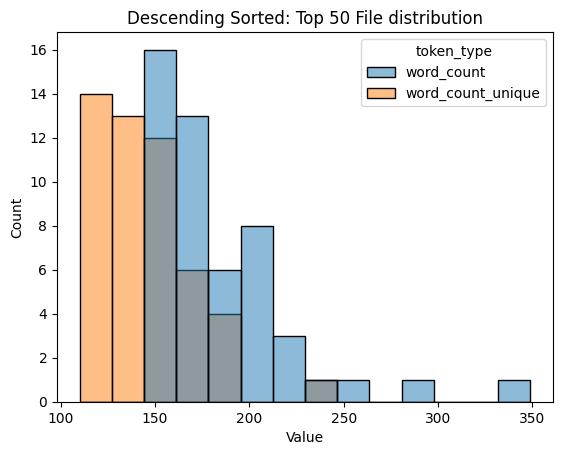

In [39]:
ax = sns.histplot(x="value", hue="token_type", data=plot_df)

ax.set(xlabel="Value", ylabel="Count")
plt.title("Descending Sorted: Top 50 File distribution")
plt.show()

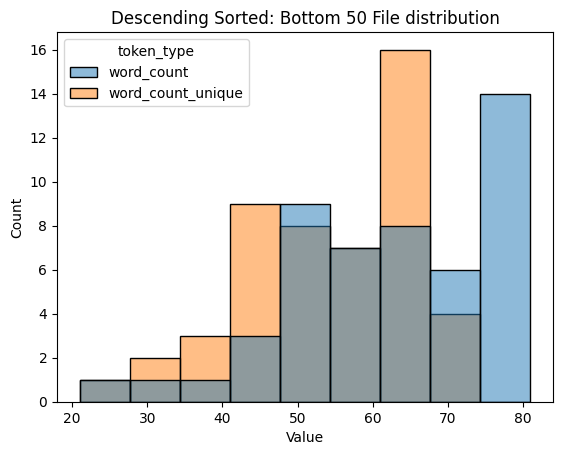

In [40]:
plot_df = pd.DataFrame(data)
plot_df = plot_df.sort_values(["word_count", "word_count_unique"], ascending=False).tail(50)
plot_df = pd.melt(plot_df, id_vars="file_name")
plot_df = plot_df.rename(columns={"variable": "token_type"})

ax = sns.histplot(x="value", hue="token_type", data=plot_df)
ax.set(xlabel="Value", ylabel="Count")
plt.title("Descending Sorted: Bottom 50 File distribution")
plt.show()

In [47]:
plot_df = pd.DataFrame(data)

In [ ]:
plot_df = pd.melt(plot_df, id_vars="file_name")

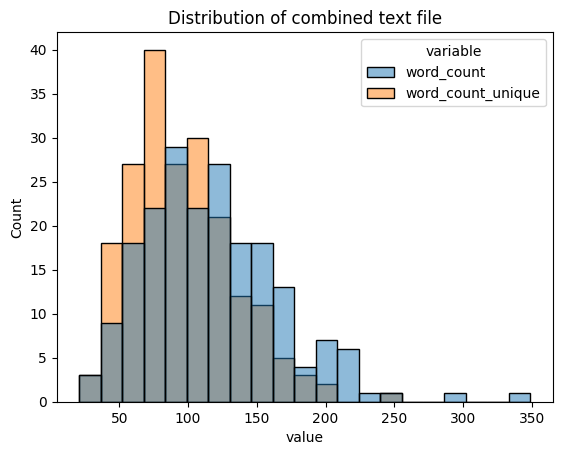

In [49]:
sns.histplot(x="value", hue="variable", data=plot_df)
plt.title("Distribution of combined text file")
plt.show()
# plot_df.head()
# sns.displot(x=plot_df["word_count_unique"], ax=ax)
# plt.title("Distribution of combined text file")
# plt.show()

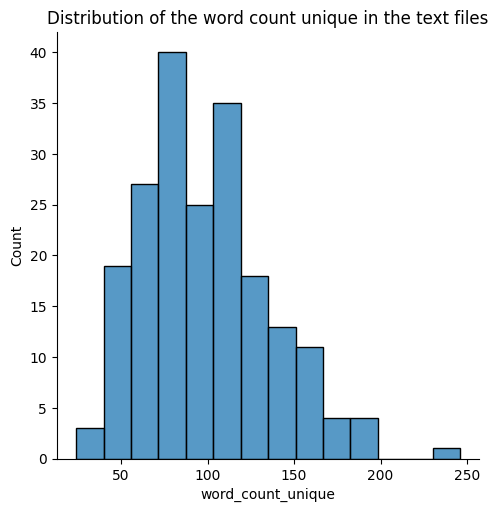

In [53]:
sns.displot(x=plot_df["word_count_unique"])
plt.title("Distribution of the word count unique in the text files")
plt.show()

<bold>Why perform the above exercise</bold>
- to understand what should be the max length value in the tokenizer
- if padding / truncation is required in the data

##### Word importance in the clinical notes

In [20]:
from wordcloud import WordCloud

In [21]:
stop_words = set(list(stop_words) + ["<emphasize>", "emphasize"])
list(stop_words)[-5:]

['being', 'to', 'what', 'yourselves', 'him']

In [22]:
"<emphasize>" in stop_words or "emphasize" in stop_words

True

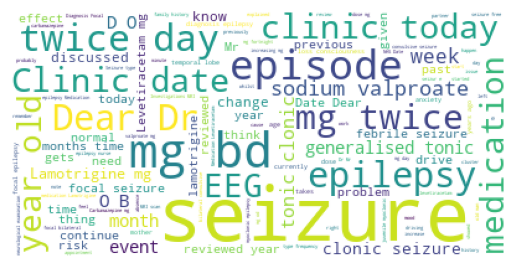

In [23]:
# Read the whole text.
whole_text = " "
# stop_words = set(list(stop_words) + ["<emphasize>"])

for _question_file_name in questions:
    with open(_question_file_name, "r") as f:
        content = f.read()
    
    filtered_words = _get_filtered_words(content)
    filtered_words = [word for word in filtered_words if word not in stop_words]
    content = " ".join(filtered_words)
    whole_text += "  " + content + " "

# Generate a word cloud image
wordcloud = WordCloud().generate(whole_text)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(
    background_color="white",
    max_words=len(whole_text), 
    max_font_size=60, 
    relative_scaling=.7).generate(whole_text)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### TF IDF

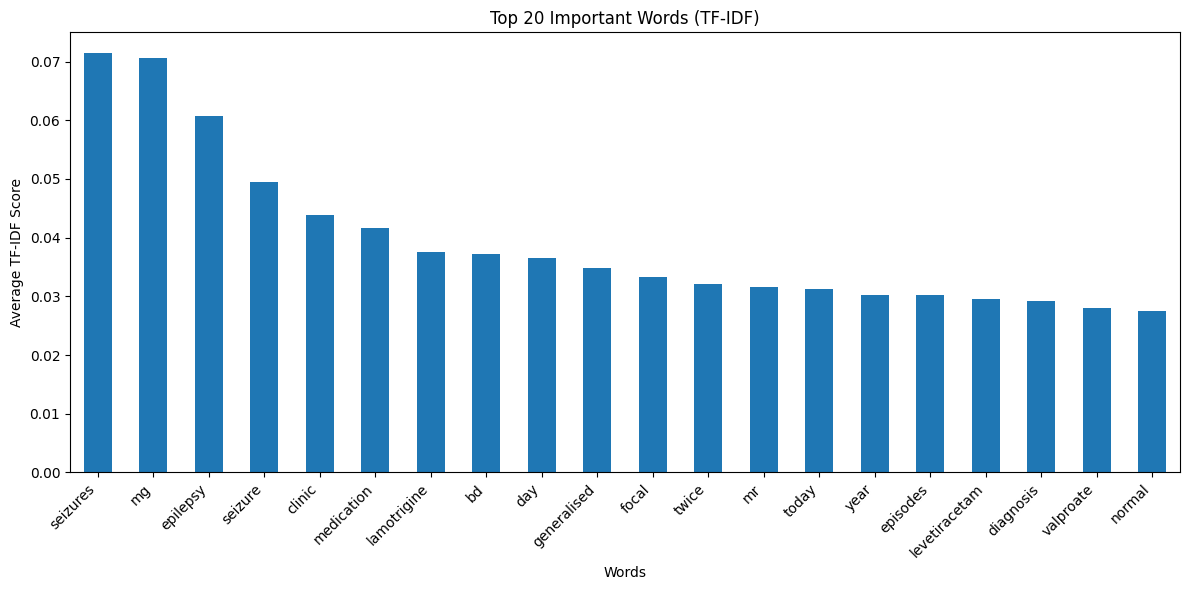

In [24]:
# Directory containing text files
directory = "data/modified_data"

# Read text files
documents = []
for filename in questions:
    with open(filename, "r") as file:
        content = file.read()
        filtered_words = [word for word in _get_filtered_words(content) if word.lower() not in stop_words]
        content = " ".join(filtered_words)
        documents.append(content)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Calculate average TF-IDF values for each term
average_tfidf = df.mean()

# Sort terms by average TF-IDF in descending order
top_terms = average_tfidf.sort_values(ascending=False)[:20]  # Select top 20 terms

# Plot the top terms
plt.figure(figsize=(12, 6))
top_terms.plot(kind="bar")
plt.title("Top 20 Important Words (TF-IDF)")
plt.xlabel("Words")
plt.ylabel("Average TF-IDF Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

##### data check for empty prescriptions

In [53]:
clinical_files = glob.glob("./data/modified_data/*.txt")
json_files = glob.glob("./data/modified_data/*.json")

In [13]:
num = 0
for clinical_file, json_file in zip(clinical_files, json_files):
    with open(json_file) as f:
        json_data = json.load(f)
    
    count = len(json_data)
    if count == 0:
        print(json_file)
        num += 1
print(num)

./data/modified_data\EA0016.json
./data/modified_data\EA0023.json
./data/modified_data\EA0024.json
./data/modified_data\EA0027.json
./data/modified_data\EA0043.json
./data/modified_data\EA0045.json
./data/modified_data\EA0053.json
./data/modified_data\EA0062.json
./data/modified_data\EA0073.json
./data/modified_data\EA0074.json
./data/modified_data\EA0076.json
./data/modified_data\EA0078.json
./data/modified_data\EA0081.json
./data/modified_data\EA0089.json
./data/modified_data\EA0094.json
./data/modified_data\EA0097.json
./data/modified_data\EA0100.json
./data/modified_data\EA0109.json
./data/modified_data\EA0118.json
./data/modified_data\EA0141.json
./data/modified_data\EA0148.json
./data/modified_data\EA0153.json
./data/modified_data\EA0164.json
./data/modified_data\EA0189.json
24


##### data check for number of prescriptions per file

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go

In [41]:
num = 0
for clinical_file, json_file in zip(clinical_files, json_files):
    with open(json_file) as f:
        json_data = json.load(f)
    
    json_count = len(json_data)
    if json_count == 0:
        continue

    seizure_json_data = [i for i in json_data if  i["entity"] == "SeizureFrequency"]

    if len(seizure_json_data) == 0:
        print(json_file)
        num += 1

print(num)

    

./data/modified_data\EA0012.json
./data/modified_data\EA0014.json
./data/modified_data\EA0015.json
./data/modified_data\EA0018.json
./data/modified_data\EA0021.json
./data/modified_data\EA0029.json
./data/modified_data\EA0030.json
./data/modified_data\EA0032.json
./data/modified_data\EA0033.json
./data/modified_data\EA0036.json
./data/modified_data\EA0037.json
./data/modified_data\EA0040.json
./data/modified_data\EA0041.json
./data/modified_data\EA0052.json
./data/modified_data\EA0091.json
./data/modified_data\EA0092.json
./data/modified_data\EA0095.json
./data/modified_data\EA0104.json
./data/modified_data\EA0114.json
./data/modified_data\EA0115.json
./data/modified_data\EA0116.json
./data/modified_data\EA0146.json
./data/modified_data\EA0149.json
./data/modified_data\EA0159.json
./data/modified_data\EA0160.json
./data/modified_data\EA0165.json
./data/modified_data\EA0166.json
./data/modified_data\EA0171.json
./data/modified_data\EA0172.json
./data/modified_data\EA0179.json
./data/mod

In [40]:
num = 0
for clinical_file, json_file in zip(clinical_files, json_files):
    with open(json_file) as f:
        json_data = json.load(f)
    
    json_count = len(json_data)
    if json_count == 0:
        continue

    prescription_json_data = [i for i in json_data if  i["entity"] == "Prescription"]

    if len(prescription_json_data) == 0:
        print(json_file)
        num += 1

print(num)


./data/modified_data\EA0039.json
./data/modified_data\EA0068.json
./data/modified_data\EA0085.json
./data/modified_data\EA0086.json
./data/modified_data\EA0113.json
./data/modified_data\EA0129.json
./data/modified_data\EA0132.json
./data/modified_data\EA0143.json
./data/modified_data\EA0157.json
./data/modified_data\EA0173.json
10


In [12]:
import pandas as pd
import glob
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
clinical_files = glob.glob("./data/modified_data/*.txt")
json_files = glob.glob("./data/modified_data/*.json")

In [9]:
plot_df = {"count": [], "file_name": [], "file_type": []}

for clinical_file, json_file in zip(clinical_files, json_files):
    with open(json_file) as f:
        json_data = json.load(f)
    
    json_count = len(json_data)
    if json_count == 0:
        continue

    pres_json_data = [i for i in json_data if  i["entity"] == "Prescription"]
    seizure_json_data = [i for i in json_data if  i["entity"] == "SeizureFrequency"]
    
    plot_df["count"].append(len(pres_json_data))
    plot_df["file_type"].append("Prescription")
    plot_df["count"].append(len(seizure_json_data))
    plot_df["file_type"].append("SeizureFrequency")
    plot_df["file_name"].append(os.path.basename(json_file))
    plot_df["file_name"].append(os.path.basename(json_file))
        
plot_df = pd.DataFrame(plot_df)
plot_df.head()

,count,file_name,file_type
0,1,EA0001.json,Prescription
1,1,EA0001.json,SeizureFrequency
2,2,EA0002.json,Prescription
3,2,EA0002.json,SeizureFrequency
4,2,EA0003.json,Prescription


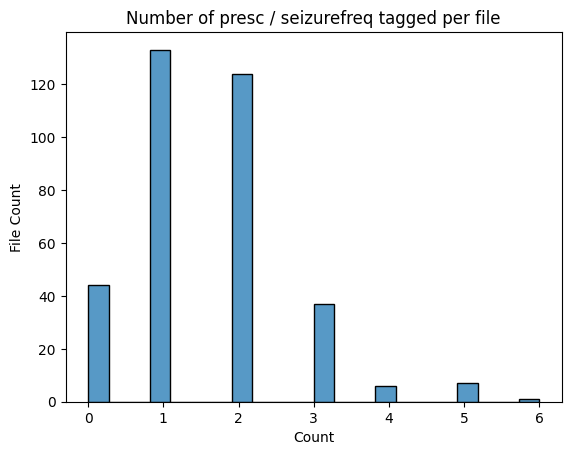

In [16]:
# plot_df = plot_df.sort_values(by=["count", "file_name"], ascending=False)
# sns.barplot(x="count", y="file_name", data=plot_df, hue="file_type")
ax = sns.histplot(x="count", data=plot_df)
ax.set(xlabel="Count", ylabel="File Count")
plt.title("Number of presc / seizurefreq tagged per file")
plt.show()

##### data check for unique json structures in the data

In [4]:
def get_format(_data):
    """
    A function to extract the data structure from the given data

    Args:
        _data: dict: data structure in dictionary format
    
    Returns:
        extracted_structure: dict
    
    Raises:
        None
    """
    extracted_structure = {}

    for key, value in _data.items():
        if isinstance(value, dict):
            extracted_structure[key] = get_format(value)
        elif isinstance(value, list):
            extracted_structure[key] = [f"<value for {key}>" for _ in range(len(value))]  # Placeholder for list elements
        else:
            extracted_structure[key] = f"<value for {key}>"  # Placeholder for other data types

    return extracted_structure

In [2]:
import glob
import json
import os

In [3]:
clinical_files = glob.glob("./data/modified_data/*.txt")
json_files = glob.glob("./data/modified_data/*.json")

In [15]:
def structure_exists(unique_structure, _structure, key):
    return any([_structure == elem for elem in unique_structure[key]])

In [16]:
unique_structure = {"prescription": list(), "seizure": list()}

def _add_data(unique_structure, data, key, json_file):
        # check for prescriptions
    if len(data) > 0:
        for _data in data:
            _structure = get_format(_data)
            if not structure_exists(unique_structure, _structure, key):
                unique_structure[key].append(_structure)
    return unique_structure

for _json_file in json_files:
    # read the json file
    with open(_json_file, "r") as f:
        json_data = json.load(f)

    pres_json_data = [i for i in json_data if  i["entity"] == "Prescription"]
    seizure_json_data = [i for i in json_data if  i["entity"] == "SeizureFrequency"]

    unique_structure = _add_data(unique_structure, pres_json_data, "prescription", _json_file)
    unique_structure = _add_data(unique_structure, seizure_json_data, "seizure", _json_file)

In [20]:
len(unique_structure["seizure"]), len(unique_structure["prescription"])

(25, 3)

In [13]:
import pprint

In [23]:
pprint.pprint(unique_structure["seizure"])

[{'attributes': {'LowerNumberOfSeizures': '<value for LowerNumberOfSeizures>',
                 'NumberOfTimePeriods': '<value for NumberOfTimePeriods>',
                 'TimePeriod': '<value for TimePeriod>',
                 'UpperNumberOfSeizures': '<value for UpperNumberOfSeizures>'},
  'end_index': '<value for end_index>',
  'entity': '<value for entity>',
  'start_index': '<value for start_index>',
  'text': '<value for text>'},
 {'attributes': {'LowerNumberOfSeizures': '<value for LowerNumberOfSeizures>',
                 'MonthDate': '<value for MonthDate>',
                 'TimeSince_or_TimeOfEvent': '<value for '
                                             'TimeSince_or_TimeOfEvent>',
                 'UpperNumberOfSeizures': '<value for UpperNumberOfSeizures>'},
  'end_index': '<value for end_index>',
  'entity': '<value for entity>',
  'start_index': '<value for start_index>',
  'text': '<value for text>'},
 {'attributes': {'NumberOfSeizures': '<value for NumberOfSeizure

In [24]:
pprint.pprint(unique_structure["prescription"])

[{'attributes': {'DoseUnit': '<value for DoseUnit>',
                 'DrugDose': '<value for DrugDose>',
                 'DrugName': '<value for DrugName>',
                 'Frequency': '<value for Frequency>'},
  'end_index': '<value for end_index>',
  'entity': '<value for entity>',
  'start_index': '<value for start_index>',
  'text': '<value for text>'},
 {'attributes': {'DrugName': '<value for DrugName>',
                 'Frequency': '<value for Frequency>'},
  'end_index': '<value for end_index>',
  'entity': '<value for entity>',
  'start_index': '<value for start_index>',
  'text': '<value for text>'},
 {'attributes': {'Frequency': '<value for Frequency>'},
  'end_index': '<value for end_index>',
  'entity': '<value for entity>',
  'start_index': '<value for start_index>',
  'text': '<value for text>'}]


#### Data Preparation

`modify the details as per instruction - output chat format`

In [25]:
import glob
import json
import os

In [26]:
clinical_files = glob.glob("./data/modified_data/*.txt")
json_files = glob.glob("./data/modified_data/*.json")

In [27]:
import pprint

In [28]:
def get_format(_data):
    """
    A function to extract the data structure from the given data

    Args:
        _data: dict: data structure in dictionary format
    
    Returns:
        extracted_structure: dict
    
    Raises:
        None
    """
    extracted_structure = {}

    for key, value in _data.items():
        if isinstance(value, dict):
            extracted_structure[key] = get_format(value)
        elif isinstance(value, list):
            extracted_structure[key] = [f"<value for {key}>" for _ in range(len(value))]  # Placeholder for list elements
        else:
            extracted_structure[key] = f"<value for {key}>"  # Placeholder for other data types

    return extracted_structure

In [29]:
_data = {'entity': 'Prescription', 'start_index': '152', 'end_index': '181', 'text': 'lamotrigine 75 mg twice a day', 'attributes': {'DrugName': 'lamotrigine', 'DrugDose': '75', 'DoseUnit': 'mg', 'Frequency': '2'}}

pprint.pprint(get_format(_data))

{'attributes': {'DoseUnit': '<value for DoseUnit>',
                'DrugDose': '<value for DrugDose>',
                'DrugName': '<value for DrugName>',
                'Frequency': '<value for Frequency>'},
 'end_index': '<value for end_index>',
 'entity': '<value for entity>',
 'start_index': '<value for start_index>',
 'text': '<value for text>'}


In [30]:
instruction_template = """Your task is to extract prescription information from a clinical text

Below is the clinical notes from a doctor, delimited by triple quotes.
clinical text: ```{clinical_text}```.

Extract the {extract_entity} only from the clinical text in JSON format. 

Give me the output in the json format as mentioned below, delimited by triple quotes
```{json_format}```.

"""

for clinical_file, json_file in zip(clinical_files, json_files):
    if os.path.basename(clinical_file) in ['EA0049.json']:
        continue
    
    # read the text file
    with open(clinical_file, "r") as f:
        txt = f.read()
    
    # replace text
    txt = txt.replace("\n", " ")
    txt = txt.replace("<emphasize>", "")

    # read the json file
    with open(json_file, "r") as f:
        json_data = json.load(f)
    
    # skip the json with empty data 
    pres_json_data = [i for i in json_data if  i["entity"] == "Prescription"]
    seizure_json_data = [i for i in json_data if  i["entity"] == "SeizureFrequency"]

    if len(pres_json_data) > 0:
        for _pres_data in pres_json_data:
            # remove the hyphen from the prescription data
            _pres_data["text"] = _pres_data["text"].replace("-", " ")
            if "DrugName" in _pres_data["attributes"]:
                _pres_data["attributes"]["DrugName"] = _pres_data["attributes"]["DrugName"].replace("-", " ")
            
            del _pres_data["entity"]
            instruction_data = instruction_template.format(
                extract_entity="Prescription",
                json_format=get_format(_pres_data),
                clinical_text=txt.replace("\u00a0", "").replace("\t", "").replace("\n", " ").replace("     ", " ")
            )
            data_line = {"instruction": instruction_data, "output": _pres_data}
            with open("./data/prescription.jsonl", "a") as f:
                json.dump(data_line, f)

    if len(seizure_json_data) > 0:
        for _seizure_data in seizure_json_data:
            del _seizure_data["entity"]
            instruction = instruction_template.format(
                extract_entity="Seizure Frequency",
                json_format=get_format(_seizure_data),
                clinical_text=txt.replace("\u00a0", "").replace("\t", "").replace("\n", " ").replace("     ", " ")
            )
            # remove the hyphen from the text file 
            _seizure_data["text"] = _seizure_data["text"].replace("-", " ")
            data_line2 = {"instruction": instruction_data, "output": _seizure_data}
            with open("./data/seizure_frequency.jsonl", "a") as f2:
                json.dump(data_line2, f2)

In [31]:
import datasets

In [32]:
def load_data(file_path):
    percent_of_train_dataset = 0.90
    data = datasets.load_dataset("json", data_files=file_path, split="train")

    split_dataset = data.train_test_split(
        train_size=int(data.num_rows * percent_of_train_dataset), seed=19, shuffle=False
    )
    train_dataset = split_dataset["train"]
    eval_dataset = split_dataset["test"]
    print(f"Size of the train set: {len(train_dataset)}. Size of the validation set: {len(eval_dataset)}")
    return train_dataset, eval_dataset

dataset_dict = {"seizure": {}, "prescription": {}}
dataset_dict["prescription"]["train_dataset"], dataset_dict["seizure"]["eval_dataset"] = load_data(
    file_path="./data/prescription.jsonl")

dataset_dict["seizure"]["train_dataset"], dataset_dict["prescription"]["eval_dataset"] = load_data(
    file_path="./data/seizure_frequency.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

Size of the train set: 264. Size of the validation set: 30


Generating train split: 0 examples [00:00, ? examples/s]

Size of the train set: 236. Size of the validation set: 27


In [33]:
dataset_dict

{'seizure': {'eval_dataset': Dataset({
      features: ['instruction', 'output'],
      num_rows: 30
  }),
  'train_dataset': Dataset({
      features: ['instruction', 'output'],
      num_rows: 236
  })},
 'prescription': {'train_dataset': Dataset({
      features: ['instruction', 'output'],
      num_rows: 264
  }),
  'eval_dataset': Dataset({
      features: ['instruction', 'output'],
      num_rows: 27
  })}}

In [34]:
dataset_dict["seizure"]["train_dataset"]["output"][0]

{'start_index': '239',
 'end_index': '276',
 'text': 'focal seizures with loss of awareness',
 'attributes': {'LowerNumberOfSeizures': '2',
  'UpperNumberOfSeizures': '3',
  'TimePeriod': 'Month',
  'NumberOfTimePeriods': '1',
  'MonthDate': None,
  'TimeSince_or_TimeOfEvent': None,
  'NumberOfSeizures': None,
  'PointInTime': None,
  'FrequencyChange': None,
  'YearDate': None,
  'LowerNumberOfTimePeriods': None,
  'UpperNumberOfTimePeriods': None,
  'AgeUnit': None,
  'AgeLower': None,
  'AgeUpper': None,
  'DayDate': None,
  'DiagCategory': None,
  'Certainty': None,
  'Negation': None}}

In [44]:
count_data = [
    len(elem["attributes"])
    for elem in dataset_dict["seizure"]["train_dataset"]["output"]
]

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

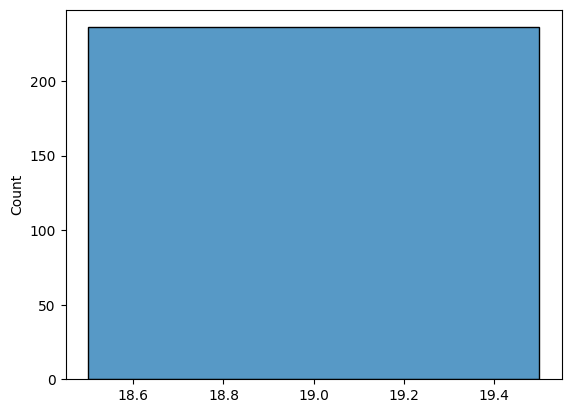

In [51]:
sns.histplot(x=count_data)
plt.show()

In [ ]:
key = ""
with open("api_key.txt", "w") as f:
    f.write(key)

In [ ]:
key = ""
with open("openai_api_key.txt", "w") as f:
    f.write(key)